In [ ]:
import numpy as np
from generator2 import gen_data
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD
from keras.layers import Input, Dense, Lambda, Activation, concatenate, Dropout
from keras.callbacks import LearningRateScheduler, EarlyStopping
from functools import partial, update_wrapper
from itertools import chain
from random import randint
import activations, losses
from keras.utils import plot_model

In [52]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [53]:
inputs = Input(shape=(72, 60, 2))

x = Conv2D(64, (3, 3))(inputs)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(256, (3, 3))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = GlobalMaxPooling2D()(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dense(256)(x)
x = Activation('relu')(x)

cnn = Model(inputs, x)

inp = Input(shape=(32, ))  # 'hsSM', 'hsWW3v2', 'hsALT', 'altID', 'target' -> dropped
x = Dense(units=256, activation='relu')(inp)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=256, activation='relu')(x)


ann = Model(inputs=inp, outputs=x)

combinedInput = concatenate([cnn.output, ann.output])
x = Dense(256, activation="relu")(combinedInput)
x = Dense(128, activation="relu")(x)
x = Dropout(0.33716497130943546)(x)
x = Dense(1, activation="softplus")(x)


model = Model(inputs=[cnn.input, ann.input], outputs=x)
model.summary()
plot_model(model, to_file='model.png')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 72, 60, 2)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 70, 58, 64)   1216        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 70, 58, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxP

In [54]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import h5py
from keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.40, step_size=4):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        if epoch >= 10 and epoch < 20:
            exponent = 1
        elif epoch >= 20 and epoch <= 118:
            exponent = 2
        else:
            exponent = 3
        return initial_lr * (decay_factor ** exponent)
    
    return LearningRateScheduler(schedule)

reduce_lr = step_decay_schedule(initial_lr=0.00025897101528140915, decay_factor=0.40, step_size=4)

opt = Adam(lr=0.00025897101528140915)


model.compile(loss='mean_squared_error',
              optimizer=opt)

data_path = ''

dataset = h5py.File(data_path, 'r')

batch_size = 128
epochs = 123
file = data_path
# train = datagen(gen_data, 101171//batch_size, file, 'train', batch_size)
# val = datagen(gen_data, 28906//batch_size, file, 'val', batch_size)
history = model.fit_generator(gen_data(file, 'train', batch_size),
                              steps_per_epoch=dataset["X_train"].shape[0]//batch_size, 
                              epochs=epochs,
                              validation_data = gen_data(file, 'test', 1024), 
                              validation_steps=dataset["X_test"].shape[0]//1024,
                              callbacks = [reduce_lr],
                              verbose = 1)
model.save('hs_models/time_drift-NoVal-CWAVE2.h5')

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/123
4442/4442 [==============================] - 435s 98ms/step - loss: 0.4846 - val_loss: 0.2282
Epoch 2/123
4442/4442 [==============================] - 170s 38ms/step - loss: 0.3098 - val_loss: 0.1896
Epoch 3/123
4442/4442 [==============================] - 170s 38ms/step - loss: 0.2795 - val_loss: 0.1676
Epoch 4/123
4442/4442 [==============================] - 169s 38ms/step - loss: 0.2601 - val_loss: 0.1612
Epoch 5/123
4442/4442 [==============================] - 173s 39ms/step - loss: 0.2495 - val_loss: 0.1564
Epoch 6/123
4442/4442 [==============================] - 173s 39ms/step - loss: 0.2409 - val_loss: 0.1611
Epoch 7/123
4442/4442 [==============================] - 173s 39ms/step - loss: 0.2329 - val_loss: 0.1476
Epoch 8/123
4442/4442 [==============================] - 173s 39ms/step - loss: 0.2271 - val_loss: 0.1399
Epoch 9/123
4442/4442 [===

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4442/4442 [==============================] - 177s 40ms/step - loss: 0.0951 - val_loss: 0.1085
Epoch 48/123
3479/4442 [======================>.......] - ETA: 32s - loss: 0.0936

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4442/4442 [==============================] - 173s 39ms/step - loss: 0.0896 - val_loss: 0.1163
Epoch 52/123
4442/4442 [==============================] - 186s 42ms/step - loss: 0.0545 - val_loss: 0.1216
Epoch 97/123
4442/4442 [==============================] - 172s 39ms/step - loss: 0.0545 - val_loss: 0.1209
Epoch 98/123
 519/4442 [==>...........................] - ETA: 2:12 - loss: 0.0494

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4442/4442 [==============================] - 175s 39ms/step - loss: 0.0524 - val_loss: 0.1218
Epoch 101/123
4442/4442 [==============================] - 174s 39ms/step - loss: 0.0523 - val_loss: 0.1240
Epoch 102/123
4442/4442 [==============================] - 174s 39ms/step - loss: 0.0524 - val_loss: 0.1267
Epoch 103/123
4442/4442 [==============================] - 176s 40ms/step - loss: 0.0519 - val_loss: 0.1320
Epoch 104/123
4442/4442 [==============================] - 176s 40ms/step - loss: 0.0514 - val_loss: 0.1245
Epoch 105/123
4442/4442 [==============================] - 172s 39ms/step - loss: 0.0507 - val_loss: 0.1274
Epoch 106/123
4442/4442 [==============================] - 176s 40ms/step - loss: 0.0504 - val_loss: 0.1223
Epoch 107/123
4442/4442 [==============================] - 174s 39ms/step - loss: 0.0500 - val_loss: 0.1216
Epoch 108/123
4442/4442 [==============================] - 169s 38ms/step - loss: 0.0500 - val_loss: 0.1242
Epoch 109/123
4442/4442 [=================

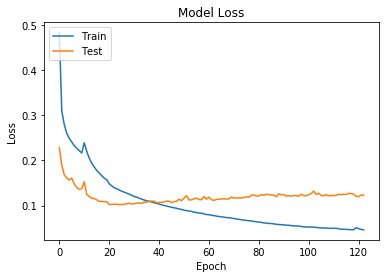

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

In [56]:
import h5py
# from keras.models import load_model
import numpy as np

# model = load_model('hs_models/combined1.h5')
dataset = h5py.File(data_path, 'r')
X = dataset['X_test']
y_true = np.array(dataset['y_test'])
y_pred = model.predict_generator(gen_data(data_path, 'test', 1024), steps = X.shape[0] // 1024 + 1, verbose=1)
y_pred = y_pred[:y_true.shape[0]]

181/181 [==============================] - 26s 144ms/step


In [57]:
residuals = y_true.reshape(-1) - y_pred.reshape(-1)

In [58]:
print(np.sqrt(np.mean((residuals)**2)))

0.3502465884955232


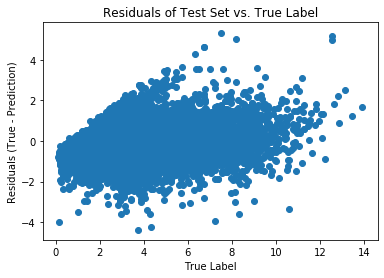

In [67]:
import matplotlib.pyplot as plt
plt.scatter(y_true, residuals)
plt.title('Residuals of Test Set vs. True Label')
plt.ylabel('Residuals (True - Prediction)')
plt.xlabel('True Label')
plt.show()

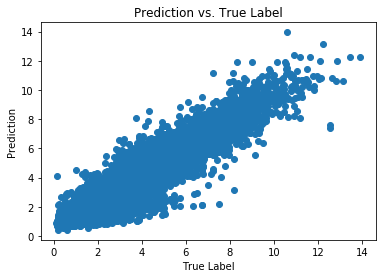

In [68]:
plt.scatter(y_true, y_pred)
plt.title('Prediction vs. True Label')
plt.ylabel('Prediction')
plt.xlabel('True Label')
plt.show()

In [69]:
hs_large = (y_true > 8).nonzero()
large_true = y_true[hs_large]
large_pred = y_pred[hs_large]

In [70]:
res = large_true.reshape(-1) - large_pred.reshape(-1)

In [71]:
print(np.sqrt(np.mean((res)**2)), len(large_true))

1.053988032031043 596


In [72]:
hs_small = (y_true < 1).nonzero()
small_true = y_true[hs_small]
small_pred = y_pred[hs_small]
small_res = small_true.reshape(-1) - small_pred.reshape(-1)
print(np.sqrt(np.mean((small_res) ** 2)), len(small_true))

0.46581795471215437 2935


In [73]:
hs_meds = np.where(np.logical_and(y_true>1, y_true<3))
meds_true = y_true[hs_meds]
meds_pred = y_pred[hs_meds]
res = meds_true.reshape(-1) - meds_pred.reshape(-1)
print(np.sqrt(np.mean((res)**2)), len(meds_true))

0.27475651392022976 124087


In [74]:
hs_medl = np.where(np.logical_and(y_true>3, y_true<8))
medl_true = y_true[hs_medl]
medl_pred = y_pred[hs_medl]
res = medl_true.reshape(-1) - medl_pred.reshape(-1)
print(np.sqrt(np.mean((res)**2)), len(medl_true))

0.44318363005862366 56959
